Bart Performance Profiling
==========================

This notebook plots performance data collected by my [instrumented fork of Bart](https://github.com/mbdriscoll/bart/tree/profiling) ([diff](https://github.com/mrirecon/bart/compare/master...mbdriscoll:profiling)).

## Experiment Conditions
  
We profiled Bart on `mikgiant`.

We measured the performance of major operations in `pics` on tasks representing the cross product of:

*  **Dimensionalities**: 2D and 3D scans.
*  **Trajectories**: Cartesian or radial.
*  **Problem sizes**: 15K to 50M ksp samples.
*  **Regularization methods**:

|   dims | method | flags |
| ------ | ------ | ----- |
| 2D, 3D | L2 | `bart pics -R Q:0.01` |
| 2D, 3D | L1 wavelet | `bart pics -R W:7:0:0.008` |
| 2D, 3D | L1 total variation | `bart pics -R T:7:0:0.008` |
| 4D | L1 wavelet | `bart pics -R W:32:0:0.001` |
| 4D | LLR | `bart pics -R L:7:7:0.001` |
| 4D | LLR+Wavelet | `bart pics -R W:7:0:.001 -R T:32:0:.001 ` |




## Setup Code

In [1]:
%matplotlib inline

import re, glob
import numpy as np
import pandas as pd
import datetime as dt
import humanize as hu
import matplotlib.pyplot as plt

from textwrap import dedent
from tabulate import tabulate
from frozendict import frozendict
from collections import defaultdict
from matplotlib.colors import hsv_to_rgb 
from matplotlib.ticker import StrMethodFormatter
from IPython.core.display import HTML, display

In [2]:
OP_TO_PATTERN = defaultdict(
    lambda: "Perfectly Parallel",
    fft = 'Fourier Transforms',
    ifft = 'Fourier Transforms',
    fwt2 = 'Wavelet Transforms',
    iwt2 = 'Wavelet Transforms',
    fwt3 = 'Wavelet Transforms',
    iwt3 = 'Wavelet Transforms',
    grid = 'Unstructured Grids',
    gridH = 'Unstructured Grids',
    unaccounted = 'Unaccounted'
)

class Event(object):
    def __init__(self, name, start=None, end=None):
        self.name = name
        self._start, self._end = start, end
        self.parent, self.children = None, []

    def add_child(self, child):
        self.children.append(child)
        child.parent = self
        
    def __getitem__(self, key):
        if isinstance(key, slice):
            evt = Event(self.name)
            for child in self.children[key]:
                evt.add_child(child)
            return evt
        else:
            return self.children[key]
        
    def dump(self, lvl=0):
        print "  "*lvl, self.name, self._start, self._end
        for child in self.children:
            child.dump(lvl+1)
        
    duration  = property(lambda self: self.end - self.start)
    depth     = property(lambda self: 1 + (self.parent.depth if self.parent else 0))
    start     = property(lambda self: self._start or min(child.start for child in self.children))
    end       = property(lambda self: self._end   or max(child.end   for child in self.children))
    max_depth = property(lambda self: 1 + max([0] + [child.max_depth for child in self.children]))
    
event_pattern = re.compile('(?P<event>[se]) (?P<name>\w+) (?P<time>\d+\.\d+)\n')

def parse_log(log, logfilename):   
    root = Event("<root>", start=0)
    stack = [root]
    for event, name, time in re.findall(event_pattern, log):     
        time = float(time)
        if event == 's':
            evt = Event(name, start=time)
            stack[-1].add_child(evt)
            stack.append(evt)
        elif event == 'e':
            evt = stack.pop()
            assert name == evt.name, [name, evt.name]
            evt._end = time   
    if len(stack) is not 1:
        print "Bad event sequence. Stack remains:", logfilename, [s.name for s in stack]
    return root

data = dict()
fname_pattern = re.compile('profile_(?P<reg>\w+)_(?P<traj>\w+)_(?P<encodes>\w+)_d(?P<dims>\d+)_t(?P<threads>\d+)_?(?P<plat>\w*).log')
for logfile in sorted(glob.glob("profile*.log")):
    params = re.match(fname_pattern, logfile).groupdict()
    params['encodes'] = tuple(int(d) for d in params['encodes'].split('x'))
    params['threads'] = int(params['threads'])
    params['dims'] = int(params['dims'])
    key = frozendict( params )
    with open(logfile, 'r') as log:
        contents = log.read()
        if contents:
            data[key] = parse_log(contents, logfile)

def tree_to_df(data, params, rows):
    times = defaultdict(float)
    try:
        duration = data.duration
    except ValueError as e:
        print "failed", params, e
        return
    stack = [data]
    while stack:
        evt = stack.pop()
        stack.extend(evt.children)
        if not evt.children:
            times[evt.name] += evt.duration/data.duration
    times_sorted = sorted(times.items(), key=lambda kv: -kv[1])
    unaccounted = 1.0 - sum(v for k,v in times_sorted)
    times_sorted.append(("unaccounted", unaccounted))
    for op, fraction in times_sorted:
        rows.append(dict(params, op=op, iter_duration=data.duration, fraction=fraction))

rows = []
for params, run in data.items():
    tree_to_df(run, params, rows)
df = pd.DataFrame(rows)
df['nelems'] = df.encodes.map(np.prod)

sametask = dict() # threads and problem size still varies
for t in df['traj'].unique():
    for r in df['reg'].unique():
        for d in df['dims'].unique():
            s = sametask[(t,r,d)] = df[(df.traj==t)&(df.reg==r)&(df.dims==d)]
df.tail()

Bad event sequence. Stack remains: profile_tv_radial_16384x2048_d2_t16.log ['<root>', 'admm']


,dims,encodes,fraction,iter_duration,op,plat,reg,threads,traj,nelems
2256,3,"(32, 32, 32)",0.006737,0.942315,zfmac,cpu,l2,12,cart,32768
2257,3,"(32, 32, 32)",0.005938,0.942315,zmul,cpu,l2,12,cart,32768
2258,3,"(32, 32, 32)",0.004760,0.942315,fftmod,cpu,l2,12,cart,32768
2259,3,"(32, 32, 32)",0.002154,0.942315,zmulc,cpu,l2,12,cart,32768
2260,3,"(32, 32, 32)",0.871244,0.942315,unaccounted,cpu,l2,12,cart,32768


In [3]:
#4D cart acquisition with llr regularization 41.9 million samples (128, 128, 128, 20); 13,695 ms; 8 threads
# 3D cart acquisition with wav regularization 16.8 million samples (256, 256, 256); 159,957 ms; 16 threads

#p = frozendict({'encodes': (256,256,256), 'traj': 'cart', 'dims': 3, 'threads': 16, 'plat': 'cpu', 'reg': 'wav'})
#data[p].dump()

# Time Breakdown vs. Problem Size

This analysis reveals the most expensive operators.

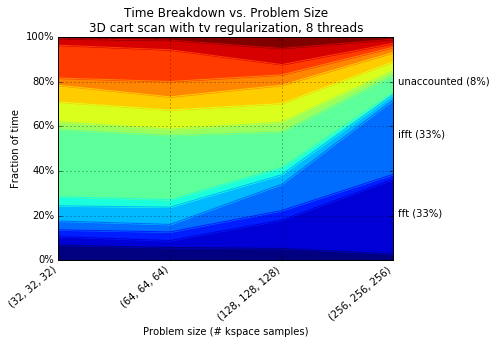

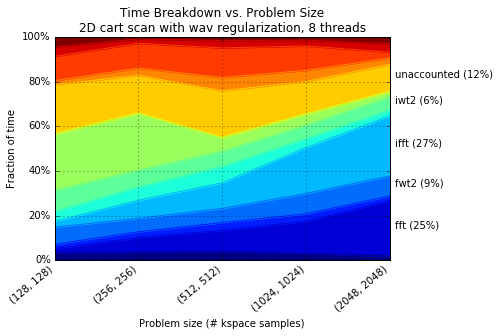

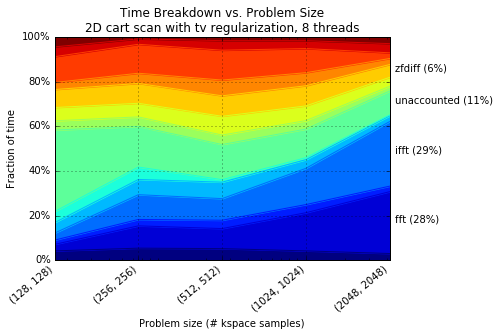

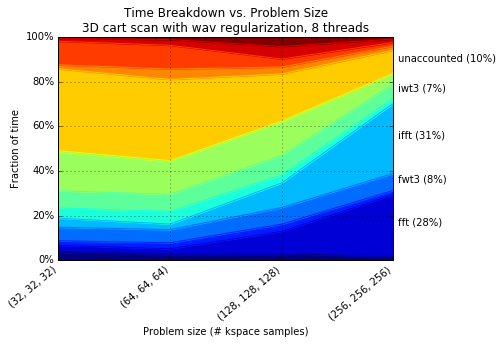

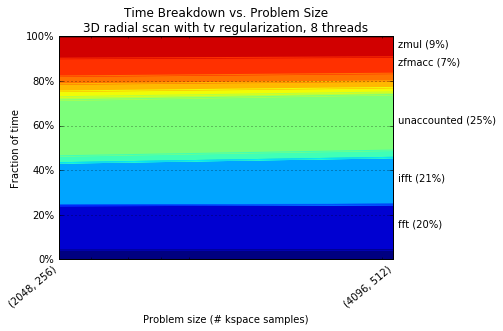

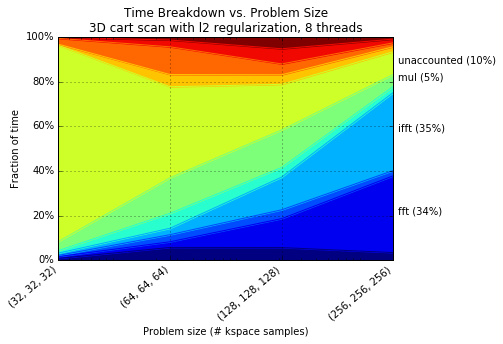

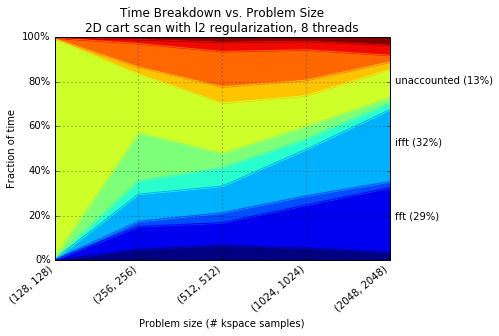

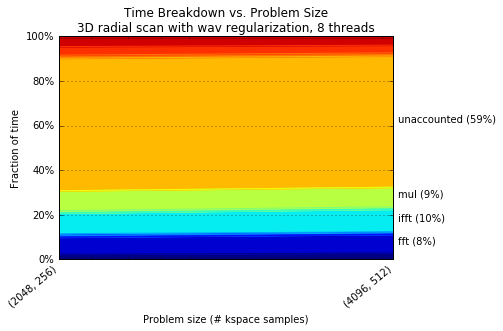

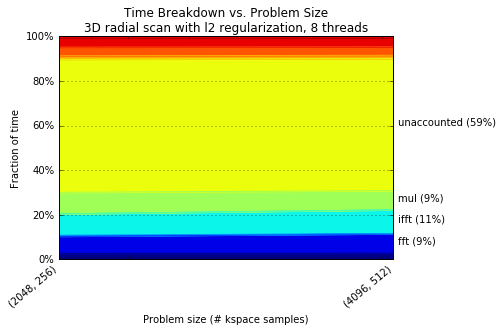

In [4]:
for (traj, reg, dims), subset in sametask.items():
    target_threads = 8
    subset = subset[ subset.threads == target_threads ].sort_values(by=['nelems'])
    table = dict()
    for name, series in subset.groupby('op'):
        if len(series.fraction):
            table[name] = np.array( series.fraction )
    index = subset.sort_values(by=['nelems']).nelems.unique()
    sizes = subset.sort_values(by=['nelems']).encodes.unique()
    try:
        table = pd.DataFrame(table, index=index)  
    except ValueError:
        continue
    
    if len(table) <= 1:
        continue

    fig = plt.figure()
    ax = fig.add_subplot(111)
    table.plot(ax=ax, kind='area', logx=True, grid=True, legend=False, ylim=(0,1), cmap='jet',
        title="Time Breakdown vs. Problem Size\n" +\
              "%sD %s scan with %s regularization, %s threads""" % (dims, traj, reg, target_threads))
    ax.set_xticks(index)
    ax.set_xticklabels(sizes, rotation=40, ha='right')
    ax.set_xlabel("Problem size (# kspace samples)")
    ax.set_ylabel("Fraction of time")
    ax.yaxis.set_major_formatter( StrMethodFormatter("{x:.0%}") )

    lastrow = table.iloc[-1]
    starts = np.hstack([[0], lastrow.cumsum()])
    midpoints = (starts[1:] + starts[:-1]) / 2
    for name, value, mp in zip(table.columns.values, lastrow, midpoints):
        if value >= 0.05:
            label = "{} ({:.0%})".format(name, value)
            ax.annotate(label, xy=(lastrow.name,mp), xytext=(5,0), textcoords='offset points')

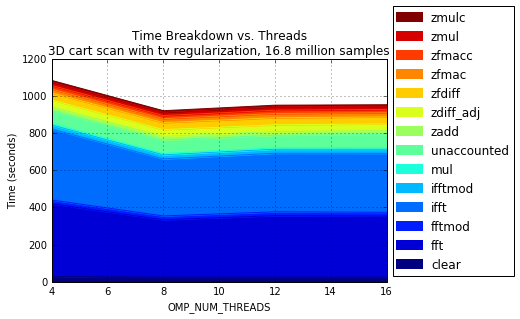

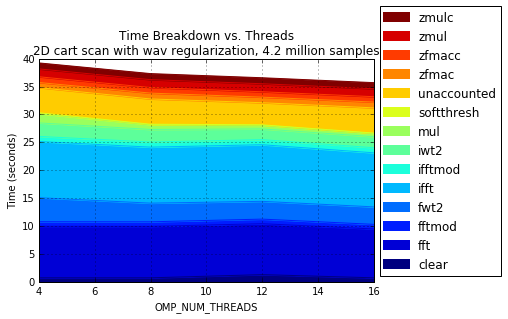

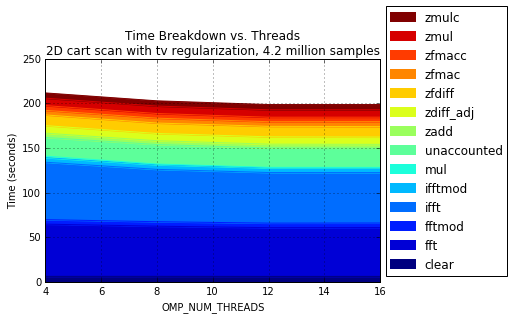

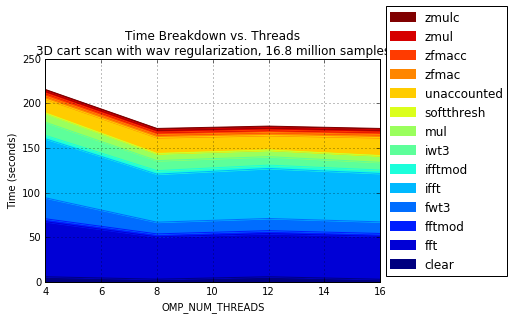

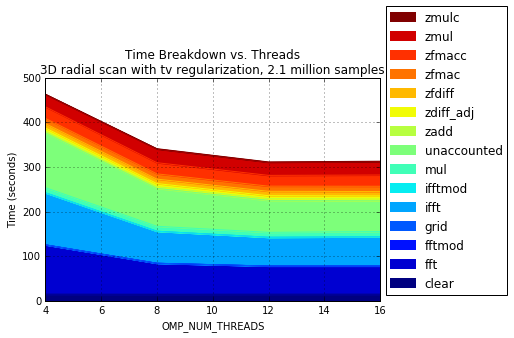

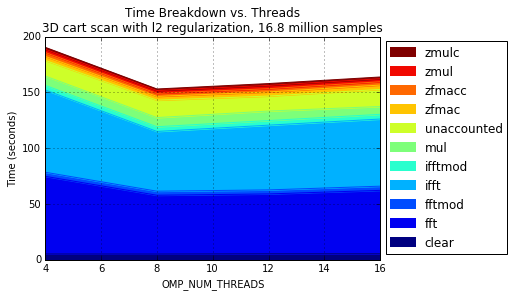

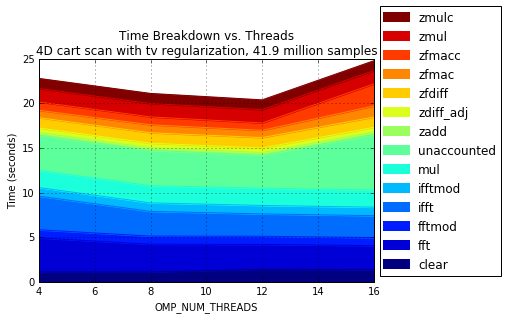

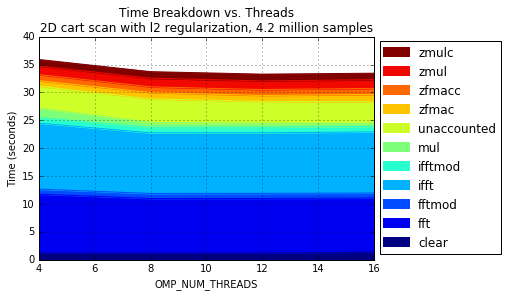

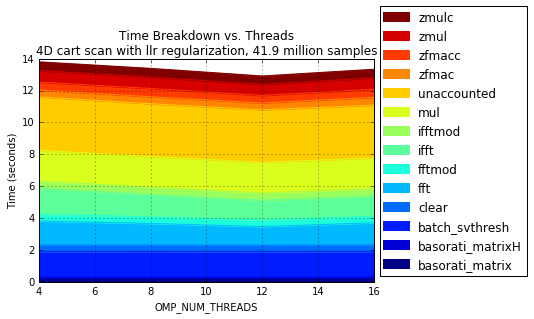

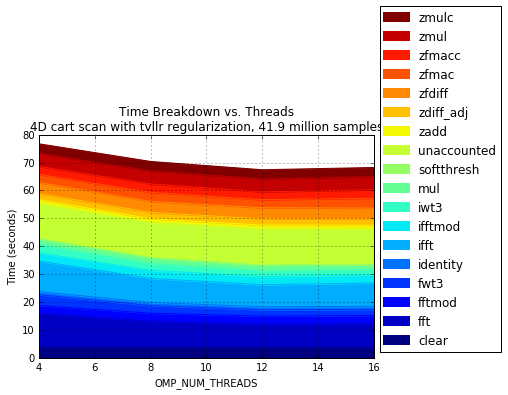

In [5]:
for (t, r, d), subset in sametask.items():
    max_elems = subset.nelems.max()
    subset = subset[ subset.nelems == max_elems ].sort_values(by=['threads'])
    table = defaultdict(list)
    for name, series in subset.groupby('op'):
        if series.fraction.size > 0:
            table[name] = np.array( series.fraction * series.iter_duration )
    index = subset.threads.unique()
    table = pd.DataFrame(table, index=index)

    if len(table) <= 1:
        continue
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    table.plot(ax=ax, kind='area', grid=True, cmap='jet',
        title="Time Breakdown vs. Threads\n" +\
              "%sD %s scan with %s regularization, %s samples""" % (d, t, r, hu.intword(max_elems)))
    ax.set_xlabel("OMP_NUM_THREADS")
    ax.set_ylabel("Time (seconds)")

    handles, labels = ax.get_legend_handles_labels()
    legend = ax.legend(handles[::-1], labels[::-1], loc=3, bbox_to_anchor=(1, 0))
    for label in legend.get_lines():
        label.set_linewidth(10)

# Single-Iteration Operator Hierarchy

This analysis plots the series of operators invoked during a single iteration.

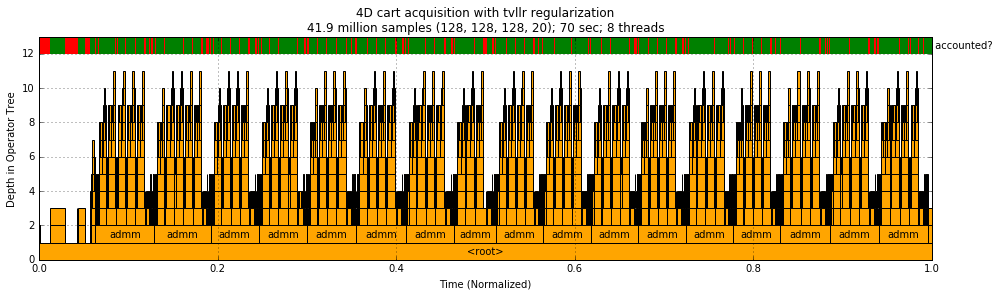

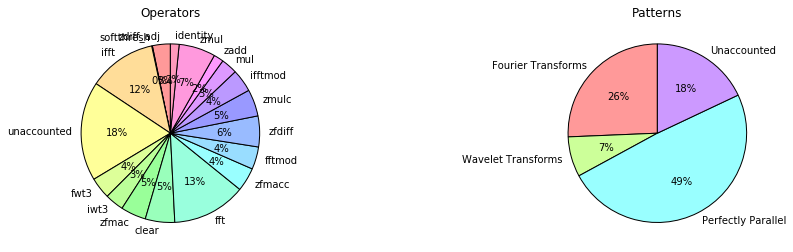

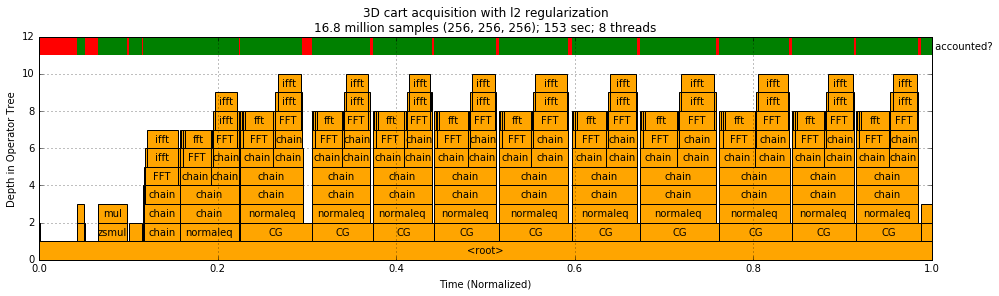

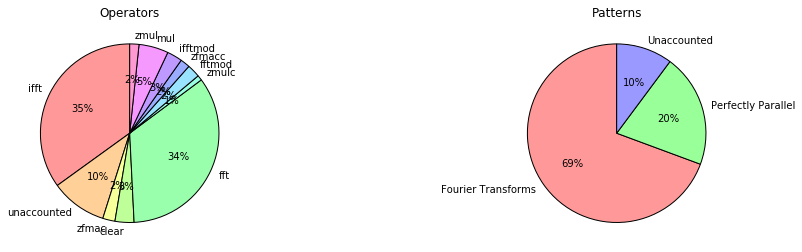

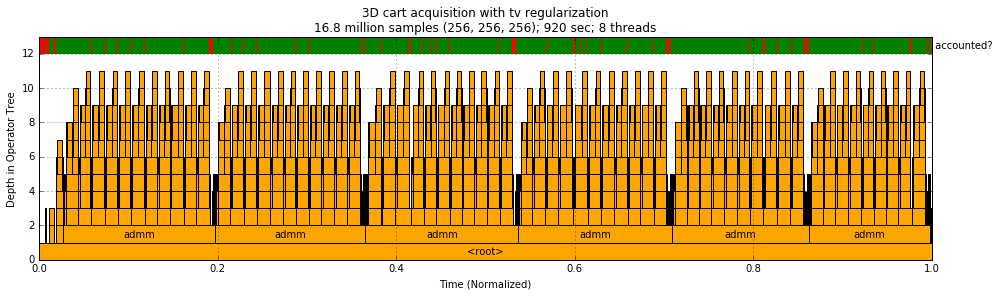

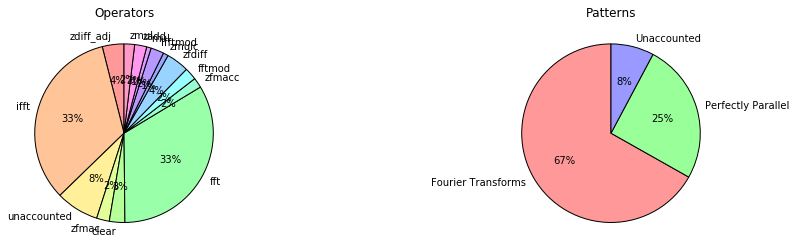

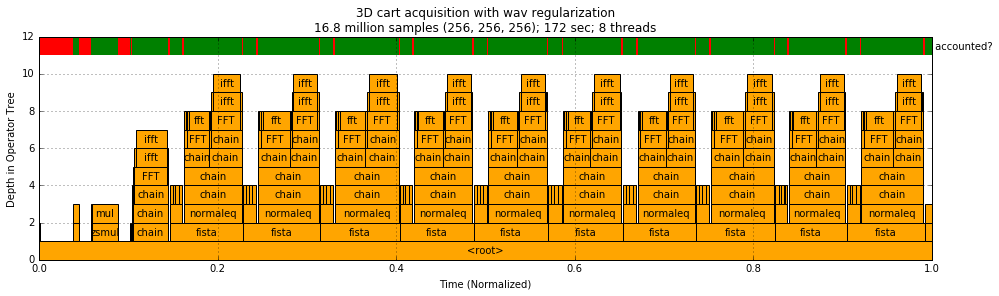

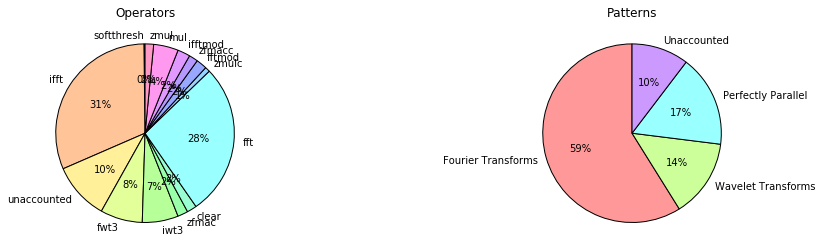

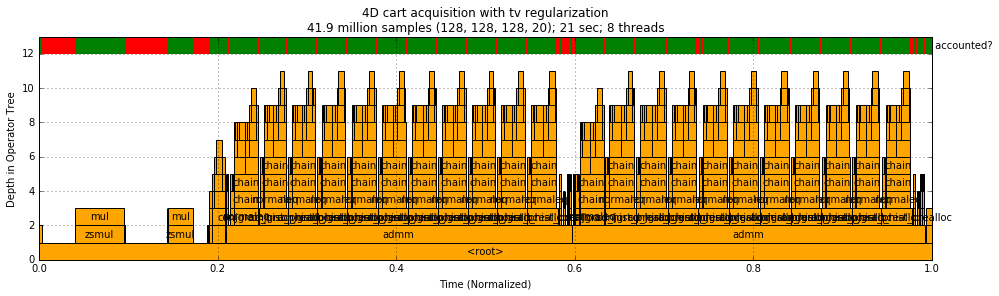

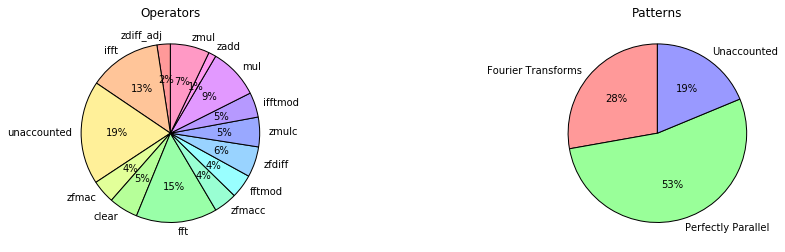

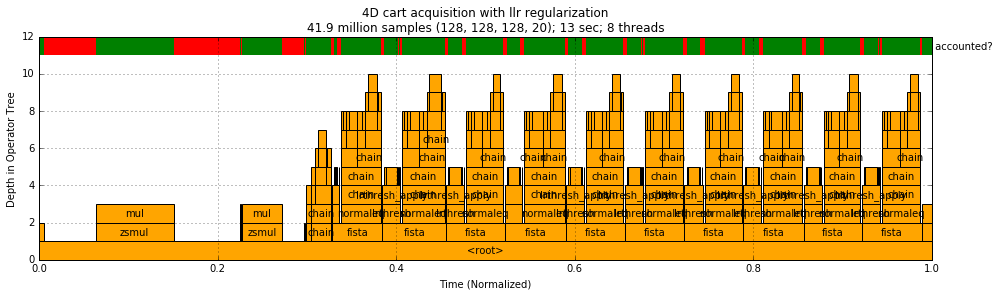

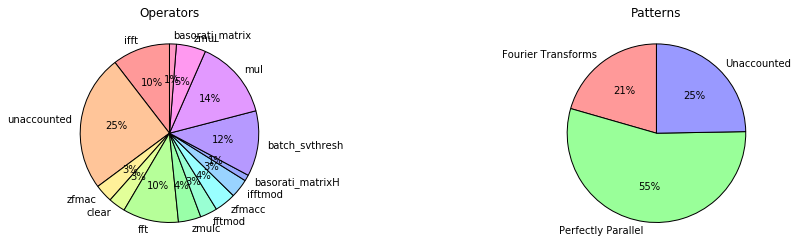

In [6]:
def plot_events(data, params):
    if np.prod(params['encodes']) < 5e6:
        return
    
    times = defaultdict(float)
    duration = data.duration
    max_depth = data.max_depth
    
    if duration < 5:
        return
    
    fig = plt.figure(figsize=(16,4))  
    plt.axhspan(max_depth+1, max_depth+2, 0, 1, fc='red', ec='none')
    plt.annotate(s=" accounted?", xy=(1,max_depth+1.5), color='k', va='center', ha='left')
    

    stack = [data]
    while stack:
        evt = stack.pop()
        stack.extend(evt.children)
        ymin, ymax = evt.depth-data.depth, evt.depth+1-data.depth
        xmin, xmax = (evt.start-data.start)/data.duration, (evt.end-data.start)/data.duration
        xy = xmin + (xmax-xmin)/2, ymin + (ymax-ymin)/2.0
        plt.axhspan(ymin, ymax, xmin, xmax, fc='orange', ec='k')
        if xmax-xmin > 0.02:
            plt.annotate(s=evt.name, xy=xy, color='k', va='center', ha='center')
        if not evt.children:
            times[evt.name] += evt.duration/data.duration
            plt.axhspan(max_depth+1, max_depth+2, xmin, xmax, fc='green', ec='none')
    title = "{dims}D {traj} acquisition with {reg} regularization\n{nencodes} "\
            "samples {encodes}; {time:,.0f} sec; {threads} threads" \
                .format(time=duration, nencodes=hu.intword(np.prod(params['encodes'])), **params) 
    display(HTML("<h2>%s</h2>" % title))
    plt.title(title)
    plt.xlabel("Time (Normalized)")
    plt.ylabel("Depth in Operator Tree")
    plt.grid()
    plt.ylim(0, max_depth+2)
    #plt.savefig("iter_{reg}_{traj}_{dims}d.pdf".format(**params), bbox_inches='tight')
    plt.show()
    
    times["unaccounted"] = 1.0 - sum(times.values())
    patterns = defaultdict(float)
    for op, fraction in times.items():
        patterns[ OP_TO_PATTERN[op] ] += fraction
    
    fig = plt.figure(figsize=(16,4))
    ax0 = fig.add_subplot(121, aspect=1, title='Operators')
    ax1 = fig.add_subplot(122, aspect=1, title='Patterns')
    labels, fracs = zip(*times.items())
    ax0.pie(fracs, labels=labels, startangle=90, autopct='%1.0f%%', colors=colors(len(fracs)))
    labels, fracs = zip(*patterns.items())
    ax1.pie(fracs, labels=labels, startangle=90, autopct='%1.0f%%', colors=colors(len(fracs)))    
    plt.show()
    
def colors(n):
    return [ hsv_to_rgb([h/float(n), 0.4, 1]) for h in range(n) ]

for i, (params, run) in enumerate(data.items()):
    if params['threads'] is not 8:
        continue
    try:
        fractions = plot_events(run, params)
    except (IndexError, ValueError) as e:
        print "FAIL", params, e